# IMPORTS

In [1]:
%load_ext blackcellmagic

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import express as px

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Functions and Setups

In [3]:
color_pal = sns.color_palette('pastel') # https://seaborn.pydata.org/tutorial/color_palettes.html
plt.style.use('fivethirtyeight') # plt.style.available
plt.style.use('ggplot')

from typing import Union

In [4]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create time series features based on time series index.

    Args:
        df (pd.DataFrame): source DataFrame

    Returns:
        pd.DataFrame: modified DataFrame
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["dayofmonth"] = df.index.day
    df["weekofyear"] = df.index.isocalendar().week
    return df

In [5]:
def get_usa_season(
    date: pd.Timestamp, return_type: str = "txt"
) -> Union[str, int, None]:
    """Return season in USA from date.

    Args:
        date (pd.Timestamp): date as pandas Timestamp format.
        return_type (str, optional): type of conversion to make. Only expects one of these ["txt", "number"]. Defaults to "txt".
            For `number` this is the mapping {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}

    Returns:
        Union[str, int, None]: season; One of ['Winter' OR 0, 'Spring' OR 1, 'Summer' OR 2, 'Fall' OR 3] or `None` if invalid.
    """
    # Create a dictionary mapping seasons to their respective month ranges
    if return_type == "txt":
        seasons = {
            "Winter": ((1, 1), (3, 20)),
            "Spring": ((3, 21), (6, 20)),
            "Summer": ((6, 21), (9, 22)),
            "Fall": ((9, 23), (12, 20)),
            "Winter": ((12, 21), (12, 31)),
        }
    elif return_type == "number":
        seasons = {
            0: ((1, 1), (3, 20)),
            1: ((3, 21), (6, 20)),
            2: ((6, 21), (9, 22)),
            3: ((9, 23), (12, 20)),
            0: ((12, 21), (12, 31)),
        }
    else:
        if isinstance(return_type, str):
            raise ValueError(
                f"""Check input of `return_type`. Only expects one of these ["txt", "number"]"""
            )
        else:
            raise TypeError(
                f"""Check input of `return_type`. Only expects one of these ["txt", "number"] as str object"""
            )

    # Convert date to a Pandas Timestamp object if it's not already
    if not isinstance(date, pd.Timestamp):
        date = pd.to_datetime(date)

    # Iterate over the seasons and check if the date falls within any range
    for season, (start_month_day, end_month_day) in seasons.items():
        start_month, start_day = start_month_day
        end_month, end_day = end_month_day

        if (
            (date.month == start_month and date.day >= start_day)
            or (date.month == end_month and date.day <= end_day)
            or (start_month < date.month < end_month)
        ):
            return season

    return None

# OBTAIN

About Dataset:

PJM Hourly Energy Consumption Data BY Rob Mulla. [Source](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

In [6]:
df = pd.read_csv('./data/PJM/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [7]:
df.head(3)

PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0

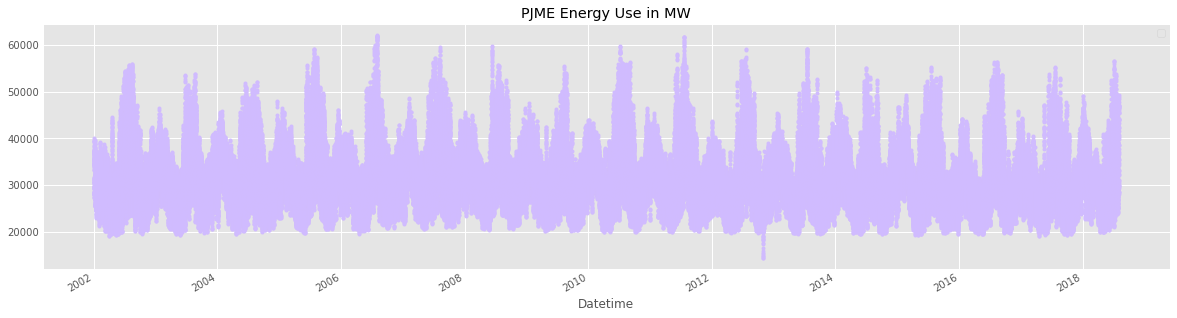

In [8]:
ax = df.plot(
    style=".", figsize=(18, 5), color=color_pal[4], title="PJME Energy Use in MW"
)
# ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.legend([])
plt.show()

In [9]:
fig = px.line(
    data_frame=df.rename(columns={"PJME_MW": "MW"}, inplace=False),
    title="PJME Energy Use in MW",
    template="plotly_dark",
)
fig.update_layout(showlegend=False)
fig.update_traces(line_color="azure", line_width=1)
fig.show()

# SCRUB

## EDA

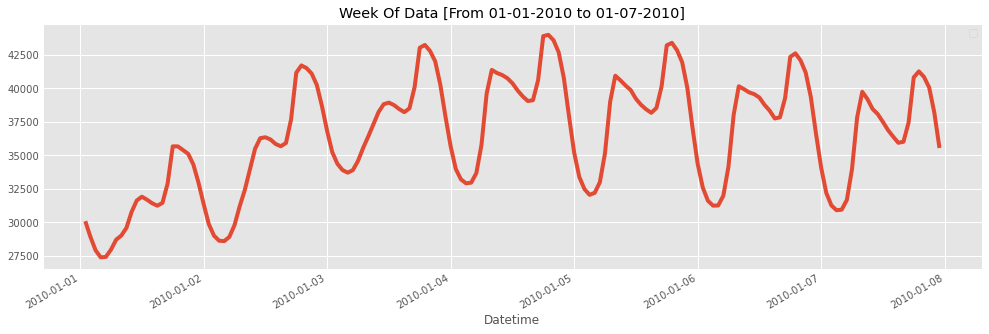

In [10]:
df.loc[(df.index > "01-01-2010") & (df.index < "01-08-2010")].plot(
    figsize=(15, 5), title="Week Of Data [From 01-01-2010 to 01-07-2010]"
)
plt.legend([])
plt.show()

## Feature Engineering

### Feature Creation

In [11]:
df = create_features(df)

### Feature / Target Relationship

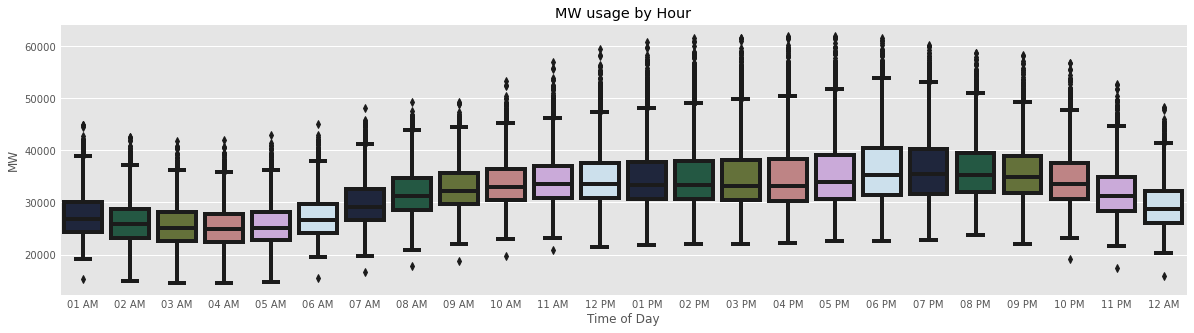

In [12]:
_ = df.copy()
_.hour = [x.strftime("%I %p") for x in df.index]
_.rename(columns={"PJME_MW": "MW", "hour": "Time of Day"}, inplace=True)

fig, ax = plt.subplots(figsize=(18, 5))
sns.boxplot(data=_, x="Time of Day", y="MW", palette=sns.color_palette("cubehelix"))
ax.set_title("MW usage by Hour")
plt.show()
del _

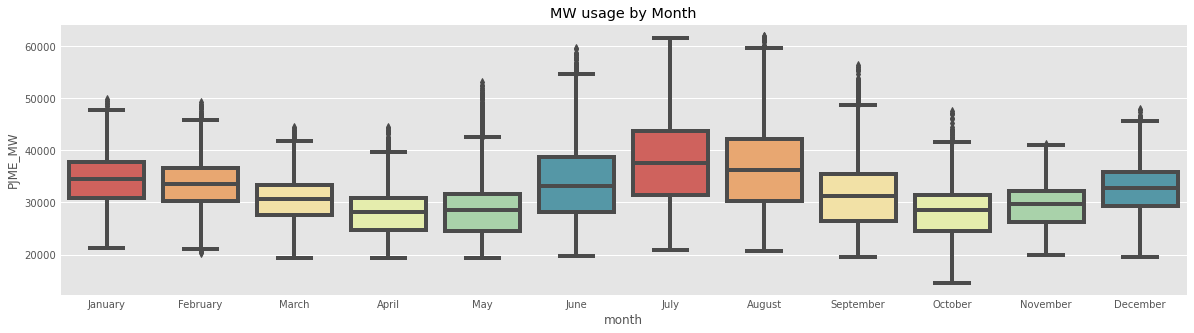

In [13]:
import calendar

month_names = list(calendar.month_name)[1:]

_ = df.copy()
_.month = df.index.month_name()

fig, ax = plt.subplots(figsize=(18, 5))
sns.boxplot(
    data=_,
    x="month",
    y="PJME_MW",
    palette=sns.color_palette("Spectral"),
    order=month_names,
)
ax.set_title("MW usage by Month")
plt.show()
del _

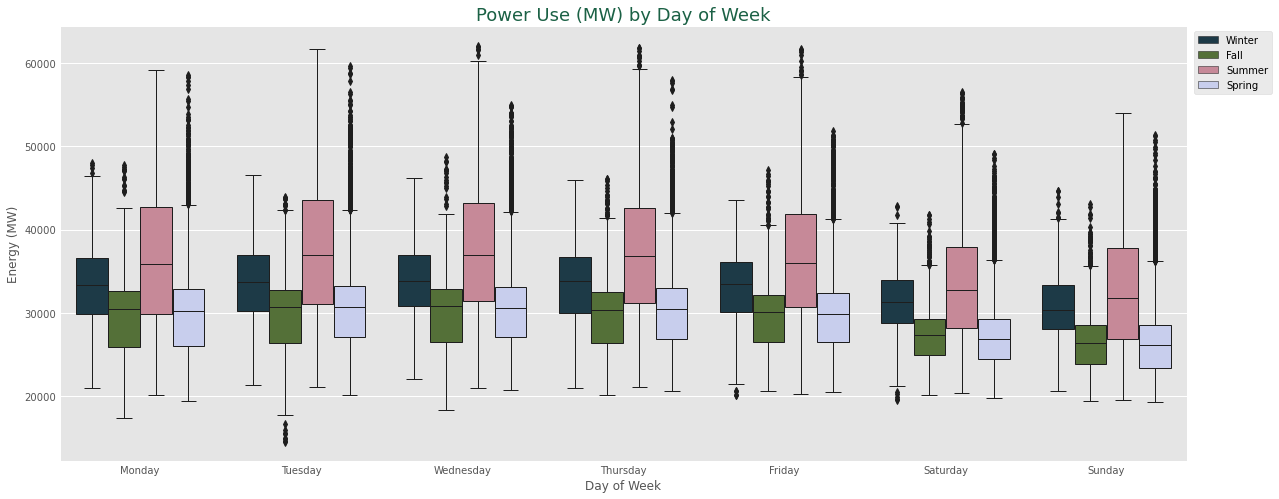

In [14]:
_ = df.copy()
_.dayofweek = df.index.day_name()
_.month = df.index.month_name()
map_q = {1: "Q1", 2: "Q2", 3: "Q3", 4: "Q4"}
_.quarter = df["quarter"].map(map_q)
_["season"] = [get_usa_season(x) for x in df.index]

fig, ax = plt.subplots(figsize=(18, 8))

sns.boxplot(
    data=_.dropna(),
    x="dayofweek",
    y="PJME_MW",
    hue="season",
    ax=ax,
    linewidth=1,
    palette="cubehelix",
    order=list(calendar.day_name)
)

ax.set_title(
    "Power Use (MW) by Day of Week",
    fontdict={
        "fontsize": 18,
        "fontweight": 5,
        "color": sns.color_palette("cubehelix")[1],
    },
)
ax.set_xlabel("Day of Week")
ax.set_ylabel("Energy (MW)")
ax.legend(bbox_to_anchor=(1.08, 1))

plt.show()

del _

# ML

## Preprocessing

### Train-Test Split

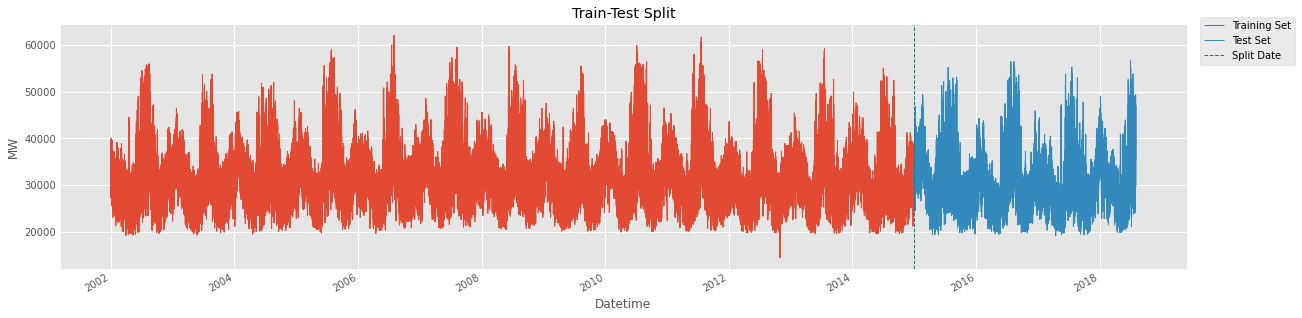

In [15]:
train = df.query("Datetime < '01-01-2015'")[['PJME_MW']]
test = df.query("Datetime >= '01-01-2015'")[['PJME_MW']]

fig, ax = plt.subplots(figsize=(18, 5))
train.plot(ax=ax, label='Training Set', title='Train-Test Split', legend='', lw=1)
test.plot(ax=ax, label='Test Set', legend="", lw=1)
ax.axvline('01-01-2015', color='teal', ls='--', lw=1)
plt.legend(['Training Set', 'Test Set', "Split Date"], bbox_to_anchor=(1.1, 1.05))
plt.ylabel("MW")
plt.show()

## Setup

In [16]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [17]:
display(
    X_train.head(),
    f"""X_train shape: {X_train.shape}""",
    y_train.head(),
    f"""y_train shape: {y_train.shape}""",
    X_test.head(),
    f"""X_test shape: {X_test.shape}""",
    y_test.head(),
    f"""y_test shape: {y_test.shape}""",
)

dayofyear  hour  dayofweek  quarter  month  year
Datetime                                                             
2002-12-31 01:00:00        365     1          1        4     12  2002
2002-12-31 02:00:00        365     2          1        4     12  2002
2002-12-31 03:00:00        365     3          1        4     12  2002
2002-12-31 04:00:00        365     4          1        4     12  2002
2002-12-31 05:00:00        365     5          1        4     12  2002

'X_train shape: (113926, 6)'

Datetime
2002-12-31 01:00:00    26498.0
2002-12-31 02:00:00    25147.0
2002-12-31 03:00:00    24574.0
2002-12-31 04:00:00    24393.0
2002-12-31 05:00:00    24860.0
Name: PJME_MW, dtype: float64

'y_train shape: (113926,)'

dayofyear  hour  dayofweek  quarter  month  year
Datetime                                                             
2015-01-01 00:00:00          1     0          3        1      1  2015
2015-12-31 01:00:00        365     1          3        4     12  2015
2015-12-31 02:00:00        365     2          3        4     12  2015
2015-12-31 03:00:00        365     3          3        4     12  2015
2015-12-31 04:00:00        365     4          3        4     12  2015

'X_test shape: (31440, 6)'

Datetime
2015-01-01 00:00:00    32802.0
2015-12-31 01:00:00    24305.0
2015-12-31 02:00:00    23156.0
2015-12-31 03:00:00    22514.0
2015-12-31 04:00:00    22330.0
Name: PJME_MW, dtype: float64

'y_test shape: (31440,)'

## XGBoost

In [18]:
reg = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    n_estimators=100_000,
    early_stopping_rounds=50,
    objective="reg:squarederror", # "reg:linear",
    max_depth=3,
    learning_rate=0.001,
    n_jobs=-1
)

In [19]:
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)

[0]	validation_0-rmse:32894.96153	validation_1-rmse:31947.05863
[50]	validation_0-rmse:31325.94112	validation_1-rmse:30379.06523
[100]	validation_0-rmse:29835.15623	validation_1-rmse:28892.29241
[150]	validation_0-rmse:28418.82854	validation_1-rmse:27480.72707
[200]	validation_0-rmse:27071.87419	validation_1-rmse:26138.59960
[250]	validation_0-rmse:25790.52518	validation_1-rmse:24863.59850
[300]	validation_0-rmse:24572.32747	validation_1-rmse:23649.23939
[350]	validation_0-rmse:23415.40460	validation_1-rmse:22495.90294
[400]	validation_0-rmse:22315.46977	validation_1-rmse:21399.12765
[450]	validation_0-rmse:21269.96595	validation_1-rmse:20356.70731
[500]	validation_0-rmse:20277.97089	validation_1-rmse:19369.43212
[550]	validation_0-rmse:19335.61542	validation_1-rmse:18432.09945
[600]	validation_0-rmse:18440.50450	validation_1-rmse:17542.27066
[650]	validation_0-rmse:17586.69349	validation_1-rmse:16694.13730
[700]	validation_0-rmse:16776.30461	validation_1-rmse:15889.39035
[750]	validat

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

### Inference

#### Feature Importance

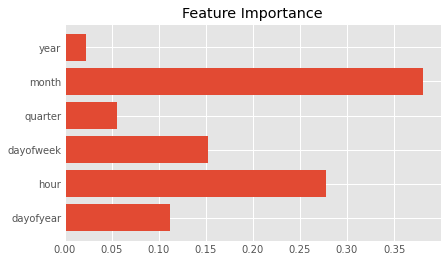

In [20]:
plt.barh(reg.feature_names_in_, reg.feature_importances_)
plt.title(label="Feature Importance")
plt.show()

In [21]:
perm_importance = permutation_importance(reg, X_test, y_test)

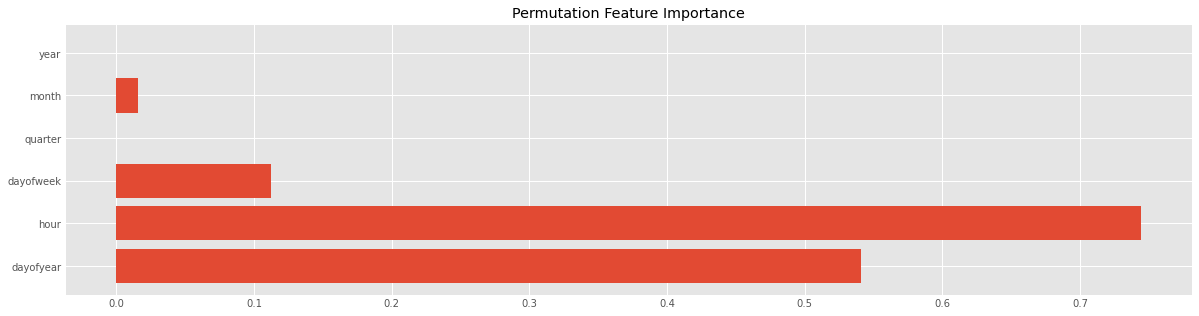

In [22]:
fig, ax = plt.subplots(figsize=(18, 5))
plt.barh(reg.feature_names_in_, perm_importance.importances_mean)
plt.title(label="Permutation Feature Importance")
plt.show()

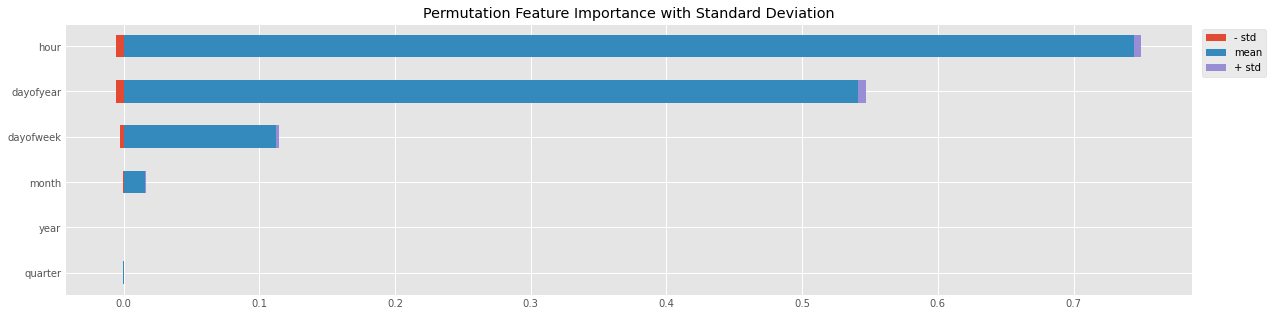

In [23]:
_ = pd.DataFrame(
    [
        reg.feature_names_in_,
        -perm_importance.importances_std,
        perm_importance.importances_mean,
        perm_importance.importances_std,
    ]
)
_ = _.T
_.set_index(0, inplace=True)
_.columns = ["- std", "mean", "+ std"]
_.sort_values(by=["mean"], axis='index', ascending=True, inplace=True)
ax = _.plot(kind="barh", stacked=True, figsize=(18, 5))
plt.title(label="Permutation Feature Importance with Standard Deviation")
ax.set(ylabel=None)
ax.legend(bbox_to_anchor=(1.07, 1))
plt.show()

### Forecast on Test Dataset

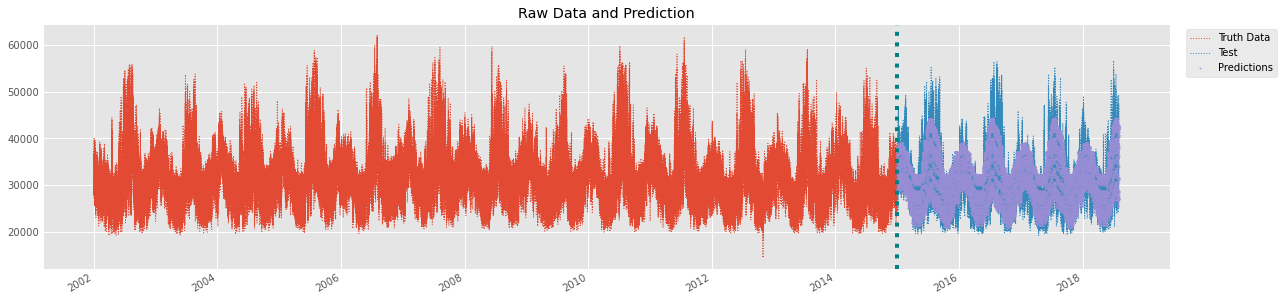

In [24]:
_test = test.copy()
_df = df.copy()
_test["prediction"] = reg.predict(X_test)
_df = _df.merge(_test[["prediction"]], how="left", left_index=True, right_index=True)

ax = train[["PJME_MW"]].plot(figsize=(18, 5), style=":", label="Train", linewidth=1)
test[["PJME_MW"]].plot(ax=ax, style=":", label='Test', linewidth=1)
_df["prediction"].plot(ax=ax, style="o", label="pred", alpha=.7, ms=1)

ax.axvline("01-01-2015", color="teal", ls=":")
plt.legend(["Truth Data", "Test", "Predictions"], bbox_to_anchor=(1.01, 1.0))
ax.set_title("Raw Data and Prediction")
ax.set(xlabel=None)
plt.show()

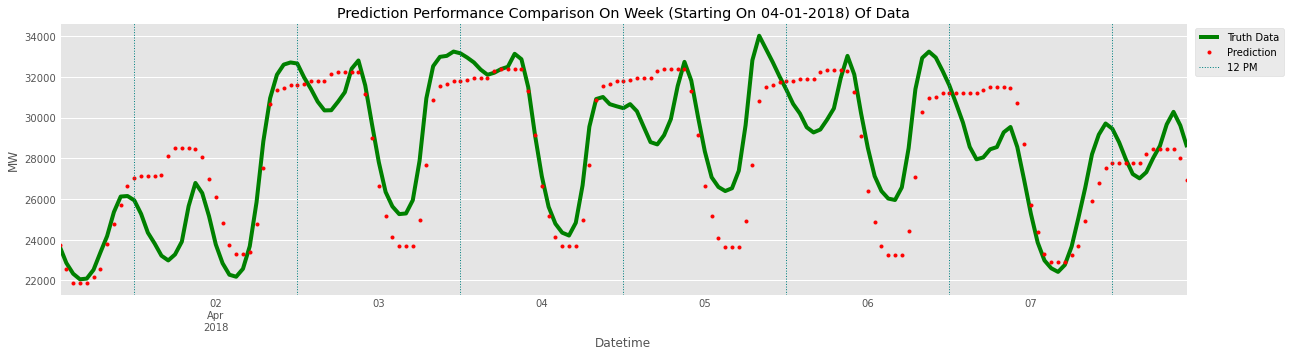

In [25]:
COMPARISON_WEEK_START = "04-01-2018"
_ = _df.query('@COMPARISON_WEEK_START < Datetime  < "04-08-2018"')

ax = _["PJME_MW"].plot(
    figsize=(18, 5),
    title=f"Prediction Performance comparison on Week (starting on {COMPARISON_WEEK_START}) Of Data".title(),
    color="g",
)
_["prediction"].plot(style=".", color="r")
for date in [x for x in _.index if x.strftime("%I %p") == "12 PM"]:
    ax.axvline(date, color="teal", linestyle=":", lw=1)
plt.legend(["Truth Data", "Prediction", "12 PM"], bbox_to_anchor=(1.09, 1.0))
plt.ylabel("MW")
del _
plt.show()

## Model Performance

### RMSE

In [26]:
score = np.sqrt(mean_squared_error(_test["PJME_MW"], _test["prediction"]))
print(f"RMSE Score on Test set: {score:0.2f}")

RMSE Score on Test set: 3725.98


### Error

In [27]:
_test["error"] = np.abs(_test[TARGET] - _test["prediction"])
_test["date"] = _test.index.date

print("Worst Predictions:")
print(
    _test.groupby(["date"])["error"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .to_string()
)

print("\nBest Predictions:")
print(
    _test.groupby(["date"])["error"]
    .mean()
    .sort_values(ascending=True)
    .head(10)
    .to_string()
)

Worst Predictions:
date
2016-08-13    12803.751058
2016-08-14    12750.402669
2016-09-10    11374.571940
2015-02-20    10975.347575
2016-09-09    10847.346273
2018-01-06    10468.662598
2016-08-12    10122.101969
2015-02-21     9886.559082
2015-02-16     9797.546061
2018-01-07     9689.857910

Best Predictions:
date
2017-10-24    337.853434
2015-10-28    408.163005
2016-10-27    535.288493
2017-10-15    547.539795
2015-05-06    550.158854
2018-05-16    574.619792
2016-09-16    665.110433
2015-10-03    669.716715
2015-11-06    674.245443
2017-04-07    675.254801


# Next Steps
- try out different models
    - Prophet | NeuralProphet [*](https://www.kaggle.com/code/antonmurashko/time-series-forecasting-with-prophet-yt) [1](https://bobrupakroy.medium.com/yes-our-favorite-fbprophet-is-back-with-multivariate-forecasting-785fbe412731) [2](https://www.microprediction.com/blog/prophet)
    - ANN: LSTM
    - ARIMA models; and its extensions like SARIMA, SARIMAX
    - scikit-learn based NN
    - LightGBM
    - AutoARIMA
    - Tsfresh | Darts | Kats [1](https://www.analyticsvidhya.com/blog/2022/05/5-python-libraries-for-time-series-analysis/) [2](https://towardsdatascience.com/3-unique-python-packages-for-time-series-forecasting-2926a09aaf5b)
- More robust cross validation for models
- Add more features (weather forecast data, holidays, major events, season)

# Notes
- add holidays
```python
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
```

- alternative feature engineering. [source](https://www.kaggle.com/code/antonmurashko/time-series-forecasting-with-prophet-yt)
```python
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

def convert_days_to_season(days):
    # Define the start day and length of each season
    spring_start = 80  # March 21st (approximate)
    summer_start = 172  # June 21st (approximate)
    fall_start = 264  # September 23rd (approximate)
    winter_start = 355  # December 21st (approximate)

    # Determine the season based on the given number of days
    if days >= spring_start and days < summer_start:
        season = "Spring"
    elif days >= summer_start and days < fall_start:
        season = "Summer"
    elif days >= fall_start and days < winter_start:
        season = "Fall"
    else:
        season = "Winter"

    return season
```

# Disclaimer
This project is heavily influenced by [`ROB MULLA`](https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt). [[YouTube - p1](https://www.youtube.com/watch?v=vV12dGe_Fho), [Youtube - p2](https://www.youtube.com/watch?v=z3ZnOW-S550) as of June 17, 2023.]